In [49]:
import os
from IPython.display import Audio
import librosa
import numpy as np
import random
import pandas as pd

import seaborn as sns

from librosa.effects import feature

import librosa.display as disp
import matplotlib.pyplot as plt
from numpy.ma.core import size
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from matplotlib.cbook import flatten

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential , load_model
from keras.layers import Dense,TimeDistributed, Conv1D,LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam





In [50]:
path=r'C:\Users\96650\Desktop\emotion'
def load_data(path):
    f_emotions = []
    f_pathes = []
    folders = os.listdir(path)

    for folder in folders:
        files = os.listdir(path + '/' + folder)
        for file in files:
            step = file.split('.')[0]
            step = step.split('-')[2]
            f_emotions.append(int(step))
            f_pathes.append(path + '/'  + folder + os.sep + file)

    return [f_emotions, f_pathes]

def get_emotion(number):
    info={1:'neutral',
          2:'calm',
          3:'happy',
          4:'sad',
          5:'angry',
          6:'fear',
          7:'disgust',
          8:'surprise'}
    return info [number]     
emotions,pathes = load_data(path)

In [51]:
def read_audio(path) :
    data,sample_rate = librosa.load(path,duration=2.4 , offset=0.6)

    return data, sample_rate

def draw_wave(path , data , sr):
    plt.figure(figsize=(10,4))
    #data,sr=librosa.load(path)
    plt.title('Audio wave :: ' +path , size=12)
    disp.waveshow(data,sr=sr)
    plt.show()

def draw_spectogram(path , data , sr):
    plt.figure(figsize=(10,4))
   # data,sr=librosa.load(path)
    X=librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.title('spectogram for wave :: ' +path , size=17)
    disp.specshow(Xdb,sr=sr , x_axis='time', y_axis='hz')
    plt.show()
   



In [52]:
def add_noise(data, sr) :
  noise= 0.035*np.random.uniform()*np.max(data)
  data+=noise * np.random.normal(size=data.shape[0])
  return data , sr

In [53]:
def shift(data,sr):
  shift_range = int(np.random.uniform(low=-5,high=5)*1000)
  shifted = np.roll(data, shift_range)
  return shifted , sr

In [54]:
def pitch (data , sr ,factor=0.6):
    pitched= librosa.effects.pitch_shift(y=data , sr=sr , n_steps=factor)
    return pitched , sr

In [55]:
def stretch (data , sr ,rate=0.85):
    stretched = librosa.effects.time_stretch(y= data , rate=rate )
    return  stretched , sr


In [56]:
##### feature_extraction mfccs:
def feature_extraction(data , sr ):
    mfcc = librosa.feature.mfcc(y=data , sr = sr)
    return mfcc

def processing_audio(data , sr , options):
    func = random.choice(options)
    if func == 'Standard':
      processed = data
    else:
      processed , _ =func (data , sr)

    return processed

In [57]:
def get_features(path):
    data, sample_rate = read_audio(path)

    function=['Standard', add_noise , pitch]
    features=[]

    func1_data = processing_audio(data, sample_rate ,function )
    func2_data = processing_audio(func1_data, sample_rate ,function )

    feature= feature_extraction(func2_data,sample_rate)
    if feature.shape==(20,104):
        features.append(feature)

    func1_data = processing_audio(data, sample_rate ,function )
    func2_data = processing_audio(func1_data, sample_rate ,function )

    feature= feature_extraction(func2_data,sample_rate)
    if feature.shape==(20,104):
        features.append(feature)

    func1_data = processing_audio(data, sample_rate ,function )
    func2_data = processing_audio(func1_data, sample_rate ,function )
    
    feature= feature_extraction(func2_data,sample_rate)
    if feature.shape==(20,104):
        features.append(feature)  
    return features   

        


    return feature_extraction(func2_data, sample_rate)

20
calm


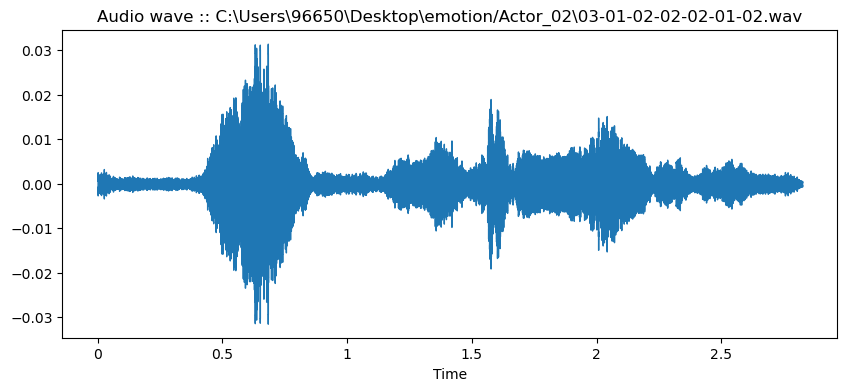

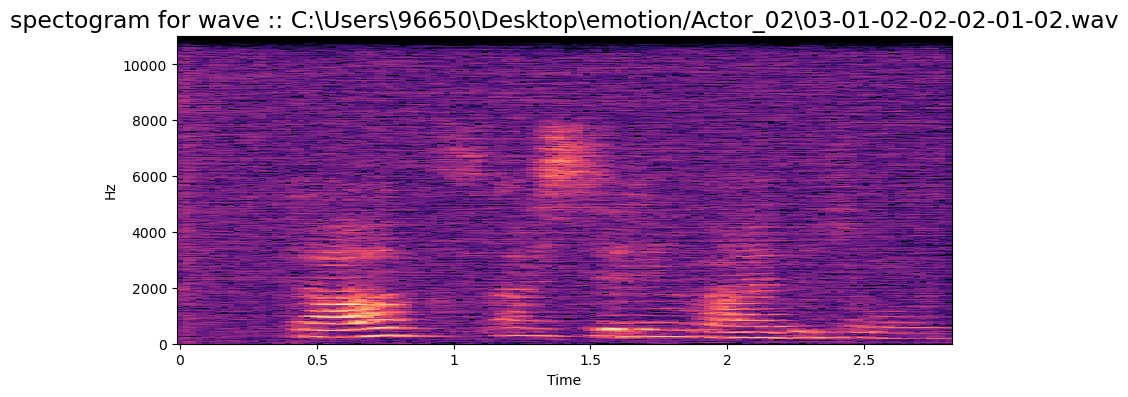

In [58]:
def display(number):

    data , sample_rate = read_audio(pathes[number])
    mfcc_features = feature_extraction (data, sample_rate)
    print(len(mfcc_features))

    print(get_emotion(emotions[number]))
    data , sample_rate = add_noise(data,sample_rate)
    data , sample_rate = shift(data,sample_rate)
    data , sample_rate = pitch(data,sample_rate)
    data , sample_rate = stretch(data,sample_rate)
    draw_wave(pathes[number] ,  data , sample_rate)
    draw_spectogram(pathes[number] ,  data , sample_rate)

    return    data , sample_rate
    #20 cofficient and distinctive transactions feature of mfcc
    #112 file lenggth

d , sr = display(70)
Audio(data=d , rate=sr)

In [59]:
X=[]
Y=[]
for indx in range(len(pathes)):
   value = get_features(pathes[indx])
   if value != []:
        for item in value:
            X.append(item) 
            Y.append(np.eye(8)[emotions[indx]-1])

In [66]:
encoder = OneHotEncoder()
encoder.fit_transform(np.array([1,2,3,4,1,5,6,7,8]).reshape(-1,1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [67]:
X[0]

array([[-5.4237268e+02, -5.0220441e+02, -5.0086060e+02, ...,
        -5.0154922e+02, -4.9799728e+02, -5.1723584e+02],
       [-7.5244179e+00, -3.9046941e+00, -4.8835092e+00, ...,
        -1.7886436e+00, -2.6773887e+00, -2.1108334e+00],
       [ 1.0447966e+01,  2.0621521e+00, -1.7866664e+00, ...,
        -9.6419406e-01, -3.3971891e+00, -4.0075436e+00],
       ...,
       [ 7.3816643e+00,  4.7153435e+00, -2.2556159e+00, ...,
         2.5027614e+00,  2.5314181e+00,  4.2887616e-01],
       [ 4.0839148e+00,  5.6808281e+00,  2.7396309e+00, ...,
         2.1034281e+00, -2.0119364e+00, -4.9427414e+00],
       [-3.9754760e-01,  2.2616872e-01, -1.4381638e+00, ...,
         2.9533496e+00,  2.7415514e-01,  6.6090322e-01]], dtype=float32)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y),test_size=0.2, random_state=11, shuffle=True)
print('train X shape',x_train.shape)
print('test X shape',x_test.shape)
print('test Y shape',y_test.shape)
print('train Y shape',y_train.shape)


train X shape (3451, 20, 104)
test X shape (863, 20, 104)
test Y shape (863, 8)
train Y shape (3451, 8)


In [69]:
# making our data compatible to model.
trainX = np.expand_dims(x_train, axis=3)
trainX = np.expand_dims(trainX, axis=3)
trainX = np.swapaxes(trainX,1,2)
print('trainX: ', trainX.shape)

testX = np.expand_dims(x_test, axis=3)
testX = np.expand_dims(testX, axis=3)
testX = np.swapaxes(testX,1,2)
print('testX: ', testX.shape)

inputShape= trainX.shape[1:]
inputShape

trainX:  (3451, 104, 20, 1, 1)
testX:  (863, 104, 20, 1, 1)


(104, 20, 1, 1)

In [71]:

def createmodel(inputShape):
    model=Sequential()
    model.add(TimeDistributed(Conv1D(32,3, padding='same', activation='relu'), input_shape=inputShape))   
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64))
    model.add(Dropout(0.2))

    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,activation='relu'))

    model.add(Dense(units=8,activation='softmax'))
    return model






In [72]:
model = createmodel(inputShape)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 104, 20, 1, 32)   128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 104, 20, 1, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 104, 640)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                180480    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [75]:
from pickle import STOP
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.6, verbose=1, patience=5, min_lr=1e-8)
stop = EarlyStopping(monitor='val_loss', patience=7)
hist = model.fit(trainX, y_train, batch_size=140, epochs=55, validation_data=(testX, y_test), callbacks=[reduce, stop])


Epoch 1/55
25/25 [==============================] - 19s 663ms/step - loss: 2.0084 - accuracy: 0.2052 - val_loss: 2.0006 - val_accuracy: 0.2178 - lr: 0.0010
Epoch 2/55
25/25 [==============================] - 15s 597ms/step - loss: 1.8692 - accuracy: 0.2724 - val_loss: 1.9669 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 3/55
25/25 [==============================] - 14s 569ms/step - loss: 1.7626 - accuracy: 0.3066 - val_loss: 1.8891 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 4/55
25/25 [==============================] - 15s 618ms/step - loss: 1.6941 - accuracy: 0.3419 - val_loss: 1.7646 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 5/55
25/25 [==============================] - 15s 595ms/step - loss: 1.6217 - accuracy: 0.3741 - val_loss: 1.8761 - val_accuracy: 0.2758 - lr: 0.0010
Epoch 6/55
25/25 [==============================] - 11s 426ms/step - loss: 1.5609 - accuracy: 0.3868 - val_loss: 1.6991 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 7/55
25/25 [==============================] - 11s 422ms/st

Text(0, 0.5, 'accuracy')

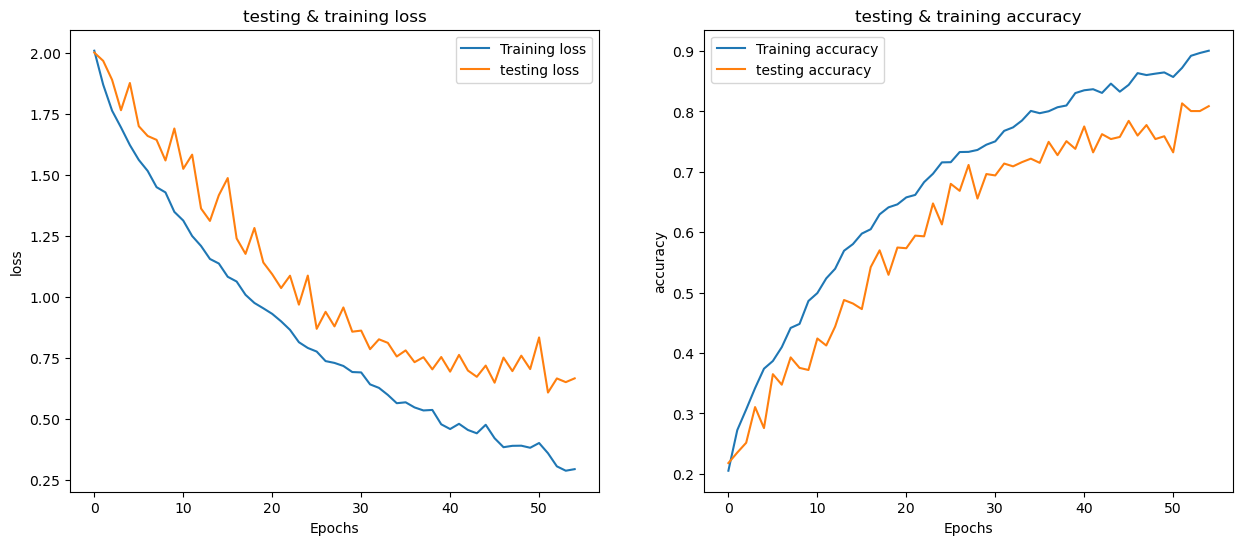

In [134]:
train_loss=hist.history['loss']
test_loss=hist.history['val_loss']
train_accuracy=hist.history['accuracy']
test_accuracy=hist.history['val_accuracy']
epochs=[value for value in range(55)]

fig , ax=plt.subplots(1,2)

ax[0].plot(epochs,train_loss , label='Training loss')
fig.set_size_inches(15,6)
ax[0].plot(epochs,test_loss , label='testing loss')
ax[0].set_title ('testing & training loss')
ax[0]. legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')

ax[1].plot(epochs,train_accuracy , label='Training accuracy')
ax[1].plot(epochs,test_accuracy , label='testing accuracy')
ax[1].set_title ('testing & training accuracy')
ax[1]. legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')

In [80]:
model.save(r'C:\Users\96650\Desktop\emotion/model4_model.h5')

In [135]:
emotion_model = load_model(r'C:\Users\96650\Desktop\model4_model.h5')
#y predict emotion
y_pred= emotion_model.predict(testX)

27/27 [==============================] - 3s 93ms/step


In [130]:
predY=encoder.inverse_transform(y_pred)
testY=encoder.inverse_transform(y_test)


emotions_predict = [get_emotion(value) for value in predY.flatten()]
emotions_actual = [get_emotion(value )for value in testY.flatten()]

df=pd.DataFrame(columns=['Actual Emotions','Predicted Emotions'])

df['Actual Emotions'] = emotions_actual
df['Predicted Emotions'] = emotions_predict

df.head(10)


,Actual Emotions,Predicted Emotions
0,surprise,surprise
1,calm,calm
2,fear,fear
3,neutral,neutral
4,sad,neutral
5,neutral,neutral
6,happy,sad
7,calm,calm
8,sad,sad
9,sad,neutral


In [146]:
file_path = input("Enter the file path of the audio to classify: ")
def process_user_input(file_path):
    data, sample_rate = read_audio(file_path)
    features = get_features(file_path)
    return features
user_input_features = process_user_input(file_path)
user_input = np.array(user_input_features)
user_input = np.expand_dims(user_input, axis=3)
user_input = np.expand_dims(user_input, axis=3)
user_input = np.swapaxes(user_input, 1, 2)
prediction = emotion_model.predict(user_input)
predicted_emotion = encoder.inverse_transform(prediction)
print("Predicted Emotion:", get_emotion(predicted_emotion.flatten()[0]))
# actual Emotion (1 = neutral, 2 = calm, 3 = happy, 4 = sad, 5 = angry, 6 = fearful, 7 = disgust, 8 = surprised).


Enter the file path of the audio to classify: C:\Users\96650\Desktop\emotion\Actor_04\test.wav
1/1 [==============================] - 1s 594ms/step
Predicted Emotion: disgust


Text(120.72222222222221, 0.5, ' Actual Emotions')

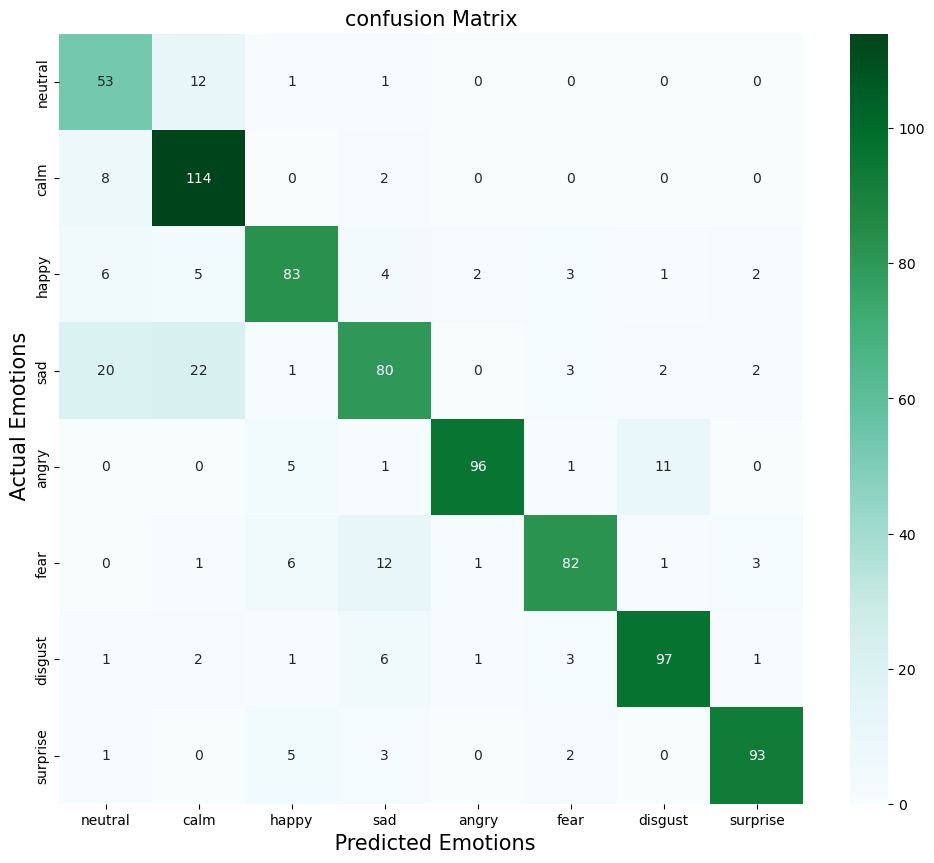

In [136]:
cm = confusion_matrix(testY, predY)
emts=[get_emotion(em) for em in encoder.categories_[0]]

cmt = pd.DataFrame(cm, index=emts , columns=emts)
plt.figure(figsize=(12,10))

sns.heatmap(cmt, annot=True ,fmt='', cmap='BuGn')
plt.title('confusion Matrix',size=15)
plt.xlabel(' Predicted Emotions',size=15)
plt.ylabel(' Actual Emotions',size=15)


